# Optimization for iceshelf transfer coefficient
### A parameter and initial condition inversion from synthetic data

The goal is to invert for correct ice-ocean melt parameters, $\gamma_T,\gamma_S$.
Where these are spatially varying fields at the ice-ocean boundary.

#### Truth
The "truth" that I'm trying to recover is from a run using the melt parameters which are functions
of the near wall velocity. See (Holland and Jenkins, 1999) for more details where they show

#### $\gamma_T = f(u_*,Pr,h,\nu)$
#### $\gamma_S = f(u_*,Sc,h,\nu)$
where
#### $u_* = C_d U_m^2$

is the friction velocity on the ice shelf, $U_m$ is the near shelf velocity in the mixed layer,
$C_d$ is the drag coefficient, $Pr,Sc$ are the Prandtl and Schmidt numbers, and $\nu$ is viscosity.

#### Initial conditions
While the goal is to recover the correct parameters $\gamma_T,\gamma_S$ (and the corresponding melt rates),
the model will need to be spun up to equilibrium, so initial conditions will also be inverted for.

#### Observations
As an additional challenge, observations are assumed to come from iStar8 and iStar9 moorings. 
Two moorings sitting off the ice edge of Pine Island Glacier. 

#### The basic steps are as follows

1. Spin up the "truth" and prior models for 3 years
    - prior model employs $\gamma_T,\gamma_S = (10^{-4},10^{-6.297})$
    - truth model uses the functional forms above
2. Gather simulated observations    
    - run truth model 1 month
    - sample $\theta,S$ fields at mooring locations, averaged for 1 month
    - add noise
3. Establish parameters and uncertainties
    - See below
4. Iterate optimization algorithm

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xmitgcm import open_mdsdataset
import MITgcmutils as mut

# Local functions
import sys
sys.path.append('../')
from pig_tools import diag_plot
import genMooringMasks as mm
import plotShiOptimUpdates as pso

In [2]:
results_dir = '/workspace/results/pig/shicoeff-optim'
truth_dir = ('%s/truth.ustar' % results_dir)
grid_dir = '/workspace/grids/pig_08'
ds = open_mdsdataset(data_dir=('%s/diags' % truth_dir),
                        grid_dir=grid_dir
                       )
ds_obs = open_mdsdataset(data_dir=('%s/obs-diags' % truth_dir),
                         grid_dir=grid_dir,
                         iters=106560
                          )
# --- Remove time from coordinates, pick first (only) time record
ds_obs = ds_obs.isel(time=0)

In [3]:
xc = ds.XC
yc = ds.YC
xg = ds.XG
yg = ds.YG

## Show $\gamma_T$ and $u^*$ "truth"

In the "truth" run, $\gamma_T$ and $\gamma_S$ are functions of the velocity near the ice-ocean interface

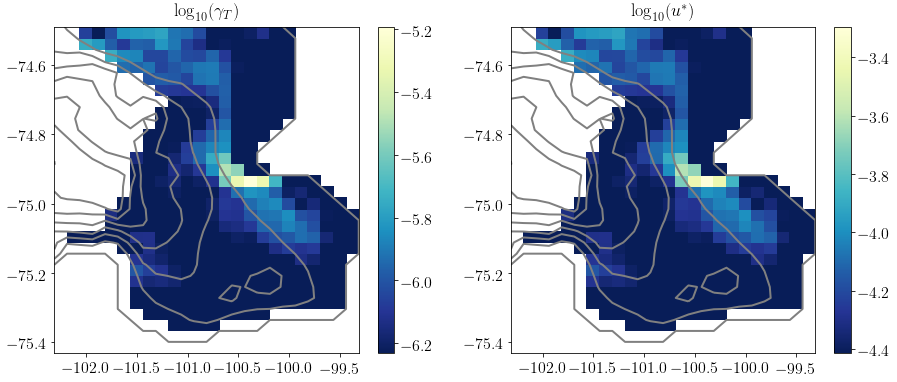

/workspace/anaconda3/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


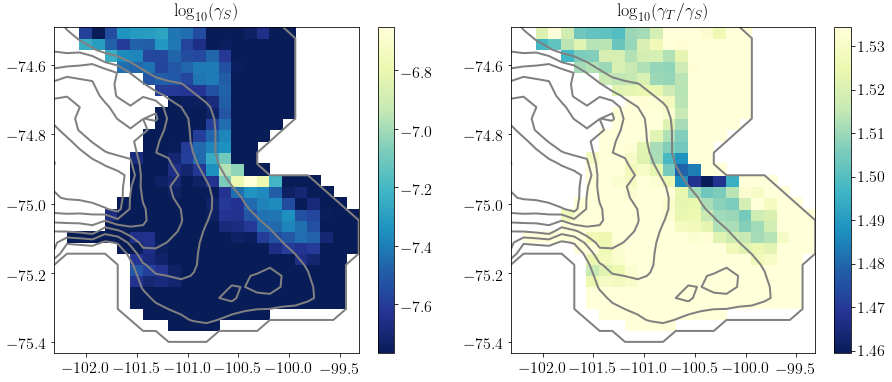

In [4]:
diag_plot(xc,yc,ds.SHIgammT,ds.SHIuStar,
         title1='$\log_{10}(\gamma_T)$',title2='$\log_{10}(u^*)$',depth=ds.Depth,log_data=True)
diag_plot(xc,yc,ds.SHIgammS,ds.SHIgammT/ds.SHIgammS,
         title1='$\log_{10}(\gamma_S)$',title2='$\log_{10}(\gamma_T/\gamma_S)$',depth=ds.Depth,log_data=True)

## Make the observations

1. Load temperature and salinity from truth run
2. Sub-sample according to mooring locations iStar8 and iStar9
3. Add noise
4. Write to file as observation mean and standard deviation 

### Generate mooring masks for subsampling

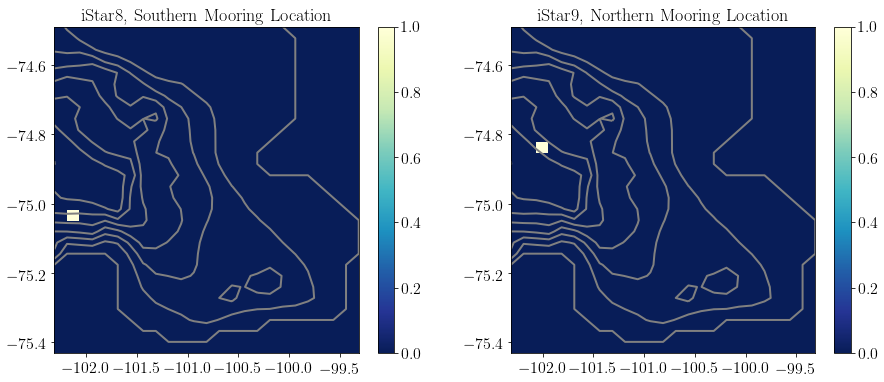

In [5]:
# Define mooring masks
lat8 = -75.059
lon8 = -102.152
lat9 = -74.863
lon9 = -102.104
mooring_depth = np.array((-380,-425,-480,-540,-610,-700))

iStar8 = mm.genMooringMask(grid=ds,lat=lat8,lon=lon8,depth=mooring_depth,mask_name='iStar8')
iStar9 = mm.genMooringMask(grid=ds,lat=lat9,lon=lon9,depth=mooring_depth,mask_name='iStar9')

diag_plot(xc,yc,iStar8.sel(Z=mooring_depth[0],method='nearest'),
                iStar9.sel(Z=mooring_depth[0],method='nearest'),
                title1='iStar8, Southern Mooring Location',
                title2='iStar9, Northern Mooring Location',
                depth=ds.Depth)

### Subsample observations and add noise

In [6]:
# Turn diagnostics from truth run into observations
theta_mean = ds_obs.THETA.where( (iStar8 + iStar9==1), np.NAN )
salt_mean = ds_obs.SALT.where( (iStar8 + iStar9==1), np.NAN )

# Add uncertainty as 1 standard deviation, normal dist.
# Not sure what to do, assuming 5% of mean value...
theta_sigma = 0.1 * theta_mean.std(skipna=True).values
salt_sigma = 0.1 * salt_mean.std(skipna=True).values

print('sigma_T = %.4f' % theta_sigma)
print('sigma_S = %.4f' % salt_sigma)


sigma_T = 0.0352
sigma_S = 0.0065


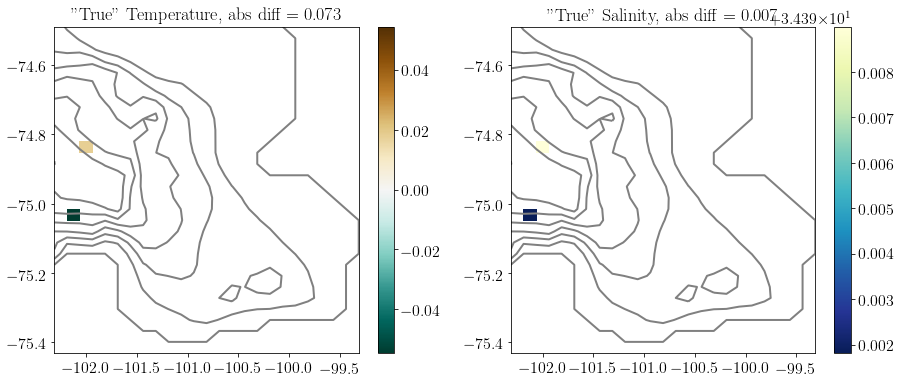

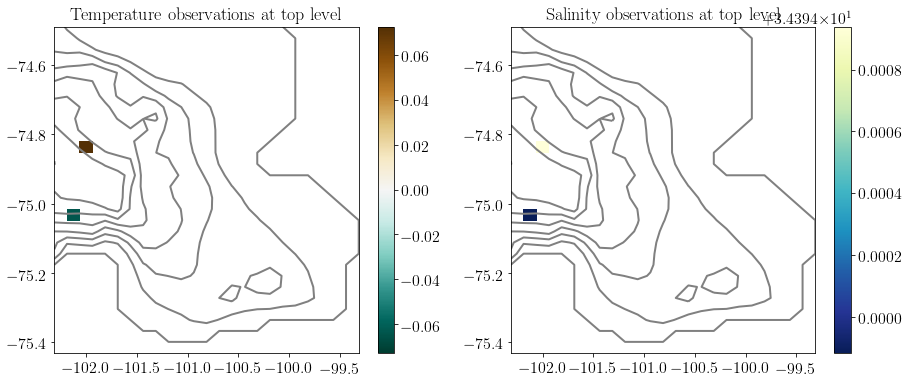

In [7]:
theta_obs = theta_mean + theta_sigma*np.random.standard_normal(size=np.shape(theta_mean.values))
salt_obs = salt_mean + salt_sigma*np.random.standard_normal(size=np.shape(salt_mean.values))

zlev = 0
theta_diff = theta_mean.where(iStar8==1,drop=True).sel(Z=mooring_depth[zlev],method='nearest').values - \
             theta_mean.where(iStar9==1,drop=True).sel(Z=mooring_depth[zlev],method='nearest').values
salt_diff = salt_mean.where(iStar8==1,drop=True).sel(Z=mooring_depth[zlev],method='nearest').values - \
             salt_mean.where(iStar9==1,drop=True).sel(Z=mooring_depth[zlev],method='nearest').values
theta_diff = np.abs(theta_diff[0,0])
salt_diff = np.abs(salt_diff[0,0])

diag_plot(xc,yc,theta_mean.sel(Z=mooring_depth[zlev],method='nearest'),
                salt_mean.sel(Z=mooring_depth[zlev],method='nearest'),
                title1=('"True" Temperature, abs diff = %.3f' % theta_diff),
                title2=('"True" Salinity, abs diff = %.3f' % salt_diff),
                depth=ds.Depth)
diag_plot(xc,yc,theta_obs.sel(Z=mooring_depth[zlev],method='nearest'),
                salt_obs.sel(Z=mooring_depth[zlev],method='nearest'),
                title1='Temperature observations at top level',
                title2='Salinity observations at top level',
                depth=ds.Depth)

### Generate observational uncertainty (weight) fields

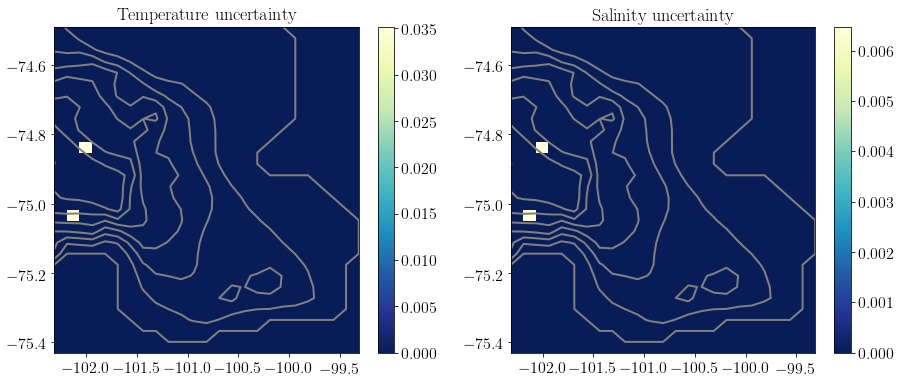

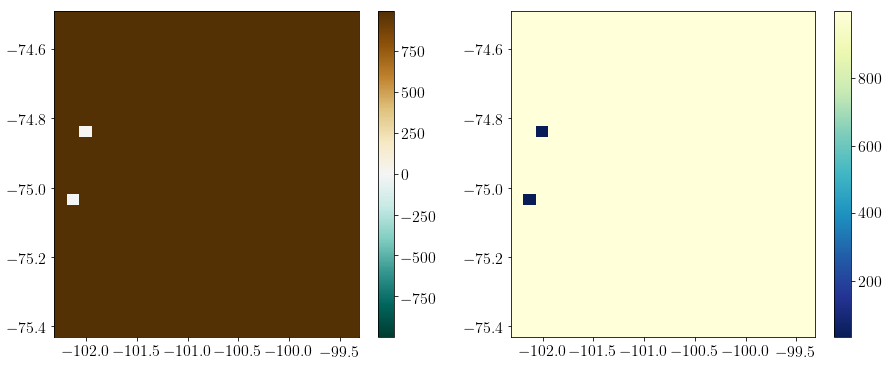

In [8]:
# Make field of uncertainty (1sigma)
theta_uncertainty = theta_sigma * np.where( iStar8+iStar9 == 1, 1, 0)
salt_uncertainty = salt_sigma * np.where( iStar8+iStar9 == 1, 1, 0)

diag_plot(xc,yc,theta_uncertainty[18,:,:],
                salt_uncertainty[18,:,:],
                title1='Temperature uncertainty',
                title2='Salinity uncertainty',
                depth=ds.Depth)

# Clean up NANs before writing out
theta_obs = theta_obs.where( (~xr.ufuncs.isnan(theta_obs)),999.0)
salt_obs = salt_obs.where( (~xr.ufuncs.isnan(salt_obs)),999.0)
diag_plot(xc,yc,
          theta_obs.sel(Z=mooring_depth[0],method='nearest'),
          salt_obs.sel(Z=mooring_depth[0],method='nearest')      
         )

### Make descriptive meta data and save

In [9]:
# --- Make some nice meta information for these 
theta_obs.attrs['description']=('Simulated THETA obs. from \n %s \n sampled at moorings via masks: \n %s \n %s' %
                                (truth_dir,iStar8.attrs['description'],iStar9.attrs['description'])
                               )
salt_obs.attrs['description']=('Simulated SALT obs. from \n %s \n sampled at moorings via masks: \n %s \n %s' %
                                (truth_dir,iStar8.attrs['description'],iStar9.attrs['description'])
                               )

print(theta_obs.attrs['description'])

Simulated THETA obs. from 
 /workspace/results/pig/shicoeff-optim/truth.ustar 
 sampled at moorings via masks: 
 iStar8 mask at
(lat,lon) = (-75.048, -102.188) 
depth = -370m -430m -470m -530m -610m -690m  
 iStar9 mask at
(lat,lon) = (-74.853, -102.062) 
depth = -370m -430m -470m -530m -610m -690m 


In [10]:
## --- Write out to file
#istar_obs_dir = '/workspace/results/pig/shicoeff-optim/istar_obs_month'
#if not os.path.isdir(istar_obs_dir):
#    os.makedirs(istar_obs_dir)
#    
## --- Comment this out if these are already written!    
#mm.writeMaskFile(theta_obs.values,('%s/theta_obs' % istar_obs_dir),
#                 comments=theta_obs.attrs['description']
#                )
#mm.writeMaskFile(salt_obs.values,('%s/salt_obs' % istar_obs_dir),
#                 comments=salt_obs.attrs['description']
#                )
#
#mm.writeMaskFile(theta_uncertainty,('%s/theta_uncertainty' % istar_obs_dir),
#                 comments=('1sigma = 5%% mean(theta at iStar locations) ~ %.2f' % theta_sigma)
#                )
#mm.writeMaskFile(salt_uncertainty,('%s/salt_uncertainty' % istar_obs_dir),
#                 comments=('1sigma = 5%% mean(salt at iStar locations) ~ %.2f' % salt_sigma)
#                )

## Make the smoothing prior

As a first step, go through optimization using ECCO framework with smooth package using formulation 
from Weaver and Courtier, (2001).
See smooth_pig.ipynb for a characterization of smoothing.

Need to decide on prior uncertainties ... As a first guess, lets choose:

**Parameters**

Prior mean is the default value from pkg/shelfice. Checks out with past studies...
- $\log_{10}(\gamma_{T})\sim\mathcal{N}(-4,1)$
- $\log_{10}(\gamma_{S})\sim\mathcal{N}(\log_{10}(0.00505\gamma_T),1)$

**Initial conditions**

All initial conditions have prior mean from 3 year spinup value
Unsure of how to specify prior uncertainty, and really just want a value that weights adjustments 
appropriately for scale of each variable. Take spatial standard deviation from last month of spinup
in prior simulation ...
- $\theta_0 \sim \mathcal{N}(\theta_{eqm},\sigma(\theta_{lm})^2)$
- $S_0 \sim \mathcal{N}(S_{eqm},\sigma(S_{lm})^2)$
- $u_0 \sim \mathcal{N}(u_{eqm},\sigma(u_{lm})^2)$
- $v_0 \sim \mathcal{N}(v_{eqm},\sigma(v_{lm})^2)$

**Note: these must be provided to pkg/ctrl as $\sigma^{-2}$, with zeros where variable not active**

### A note on log10ctrl feature

This seems like a good idea because without controlling the exponent
- Control updates can cause parameter to go negative with broad enough prior
    - this happened with $\gamma_S$ in first iteration, with $\sigma = 10^{-7}$m/s
    - Can enforce with bounds, but seems like a forced solution with a more elegant fix
- How to define prior uncertainty for something that varies multiple orders of magnitude?
    - Don't want $\sigma$ too small so that prior guess is too confident
    - But don't want it so broad that updates go negative

### Load prior spinup for last month and compute standard deviation

In [11]:
ds_prior = open_mdsdataset(data_dir='/workspace/results/pig/shicoeff-optim/spinup.shiOptim/diags',
                         grid_dir=grid_dir,
                         prefix='state_3d'
                        )

/workspace/xmitgcm/xmitgcm/mds_store.py:812: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/shicoeff-optim/spinup.shiOptim/diags. Using default version.
  "in %s. Using default version." % data_dir)


In [12]:
sigma_theta = ds_prior.THETA.where(ds_prior.maskCtrlC == 1,drop=True).std(skipna=True).values
sigma_salt  = ds_prior.SALT.where(ds_prior.maskCtrlC == 1,drop=True).std(skipna=True).values
sigma_uvel  = ds_prior.UVELMASS.where(ds_prior.maskCtrlW == 1,drop=True).std(skipna=True).values
sigma_vvel  = ds_prior.VVELMASS.where(ds_prior.maskCtrlS == 1,drop=True).std(skipna=True).values

print('sigma(theta_lm)) = %.4f' % sigma_theta)
print('sigma(salt_lm)) = %.4f' % sigma_salt)
print('sigma(uvel_lm)) = %.4f' % sigma_uvel)
print('sigma(vvel_lm)) = %.4f' % sigma_vvel)

sigma(theta_lm)) = 0.8361
sigma(salt_lm)) = 0.1976
sigma(uvel_lm)) = 0.0194
sigma(vvel_lm)) = 0.0181


In [13]:
# --- 2D parameters
logshict_weights = np.power(1.0, -1) *ds.maskCtrlI.isel(Z=0).copy().values
logshics_weights = np.power(1.0, -1) *ds.maskCtrlI.isel(Z=0).copy().values

# --- 3D initial conditions
theta_weights = np.power(sigma_theta, -2) *ds.maskCtrlC.copy().values
salt_weights  = np.power(sigma_salt, -2) *ds.maskCtrlC.copy().values
uvel_weights  = np.power(sigma_uvel, -2) *ds.maskCtrlW.copy().values
vvel_weights  = np.power(sigma_vvel, -2) *ds.maskCtrlS.copy().values

In [14]:
## --- Write them out
#weights_dir = '/workspace/results/pig/shicoeff-optim/pig_prior_08'
#if not os.path.isdir(weights_dir):
#    os.makedirs(weights_dir)
#
## --- Comment this out, already written    
#mm.writeMaskFile(logshict_weights,('%s/weights_logshict' % weights_dir),comments='sigma^2 = 1.0 at maskCtrlI points')    
#mm.writeMaskFile(logshics_weights,('%s/weights_logshics' % weights_dir),comments='sigma^2 = 1.0 at maskCtrlI points')    
#
#mm.writeMaskFile(theta_weights,('%s/weights_theta' % weights_dir),comments='sigma^2 = 1degC at maskCtrlC points')    
#mm.writeMaskFile(salt_weights,('%s/weights_salt' % weights_dir),comments='sigma^2 = 0.5psu at maskCtrlC points')    
#mm.writeMaskFile(uvel_weights,('%s/weights_uvel' % weights_dir),comments='sigma^2 = 0.01m/s at maskCtrlW points')    
#mm.writeMaskFile(vvel_weights,('%s/weights_vvel' % weights_dir),comments='sigma^2 = 0.01m/s at maskCtrlS points')    

# Check out sensitivity to cost function and optim updates

Consider the control variables $u_T, u_S$ as the non-dimensional parameters and $m_T, m_S$ = $\gamma_T, \gamma_S$

So for each,

#### $u = \Gamma_{prior}^{-1/2} \log_{10}m$
#### $\log_{10}(m) = \mathcal{A}u = \Sigma C^{1/2} u$

where $\mathcal{A}$ and $\Gamma_{prior}^{1/2}$ are inverses of one another, 
$\Sigma$ is a matrix of standard deviations, and
$C^{1/2}$ is computed as in Weaver and Courtier (2001).

For each optimization iteration

#### $u_k = u_0 + \delta u_k$

where $\delta u_0=0$ and because $u_0$ is constant $\mathcal{A}u = u_0/\sigma + \mathcal{A}\delta u$

($u_0/\sigma$ is what the user provides)

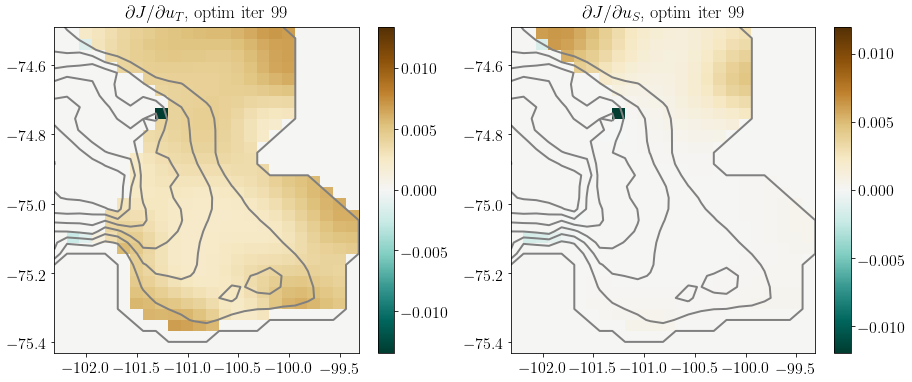

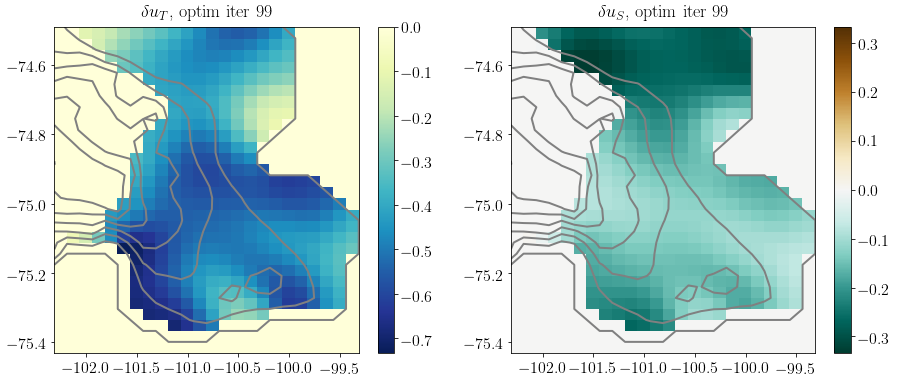

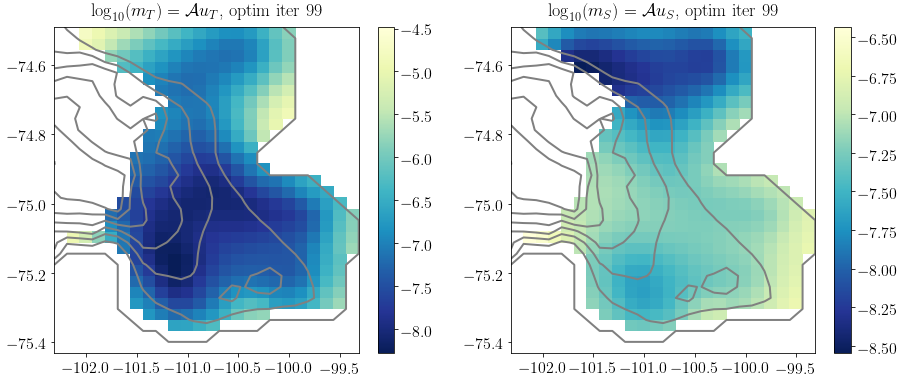

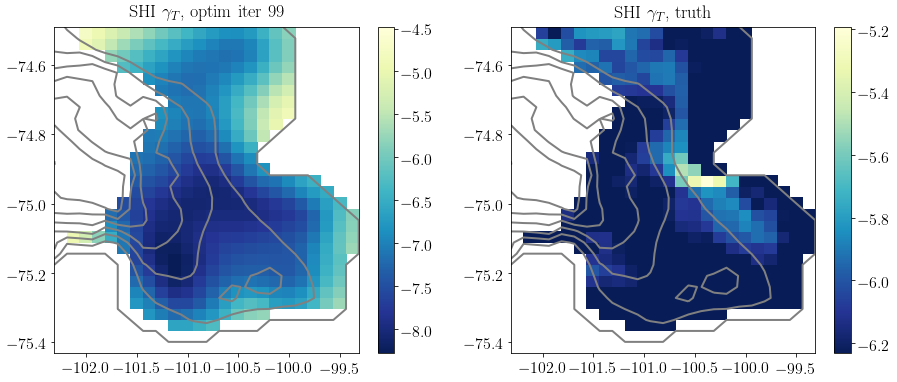

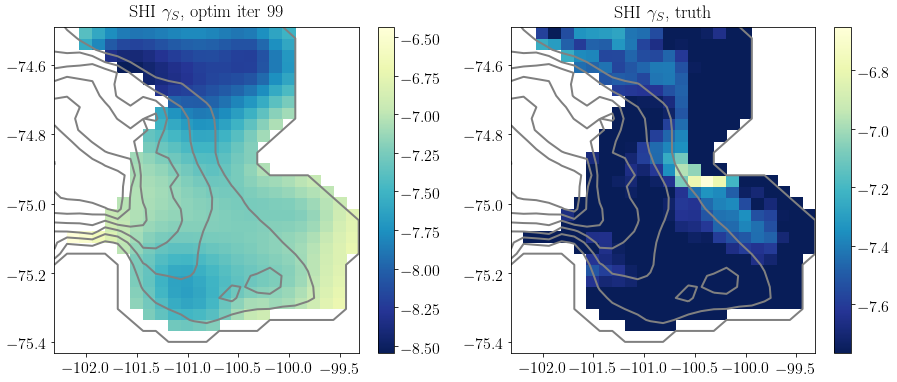

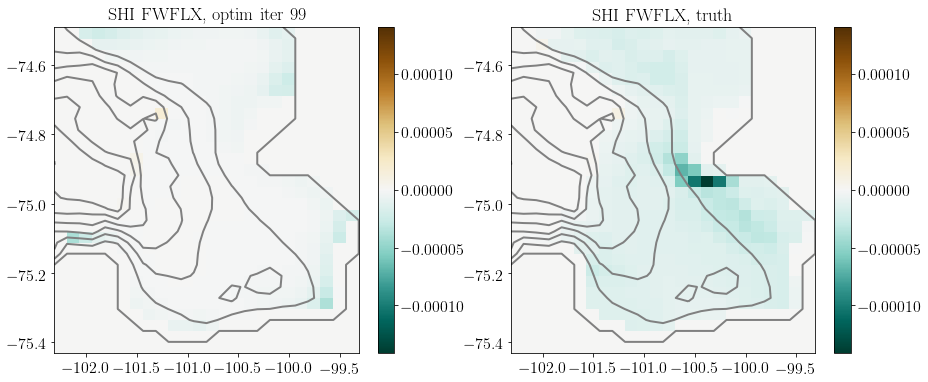

/workspace/xmitgcm/xmitgcm/mds_store.py:812: UserWarning: Couldn't find available_diagnostics.log in /workspace/grids/pig_08. Using default version.
  "in %s. Using default version." % data_dir)


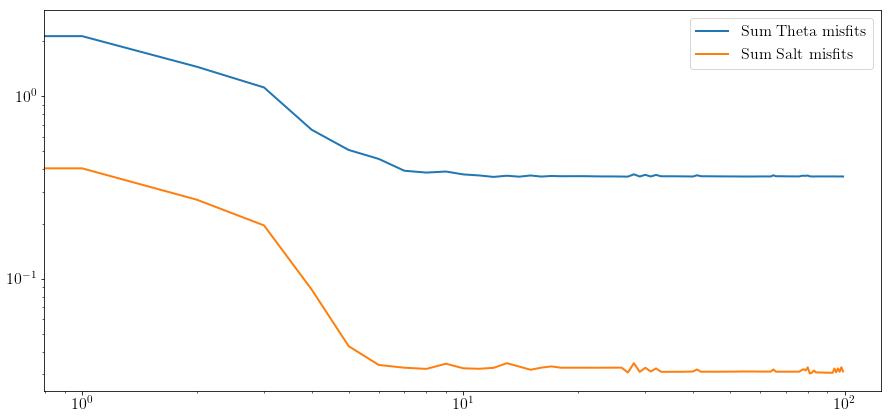

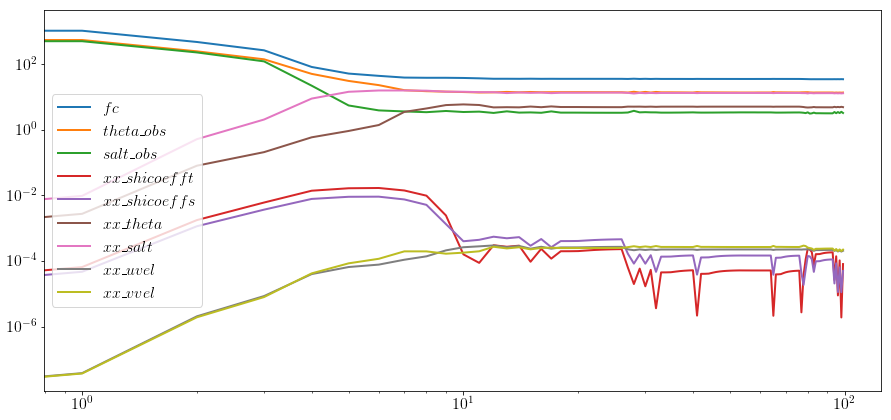

In [15]:
run_dir_prefix = '/workspace/ase-adjoint/pig/generic/shicoeff_optim_istar_month/run_ad_08'

pso.plotShiOptimUpdates(run_dir_prefix,99)
pso.plotAvgMisfits(run_dir_prefix,99)
pso.plotShiCostFunction(run_dir_prefix,99)

### Notes

- The objective function becomes stale after about 10 iterations once adjustments to IC's dominate model-data misfit
- This means I'm putting more trust into the prior than I should
- Cost due to coefficients has biggest improvement at iter 10 and 30, not sure where noise is from ... 

## Initial condition adjustments

 Using truth associated with 1 month objective function, not last week 
   truth_dir = /workspace/results/pig/shicoeff-optim/truth.ustar/diags 


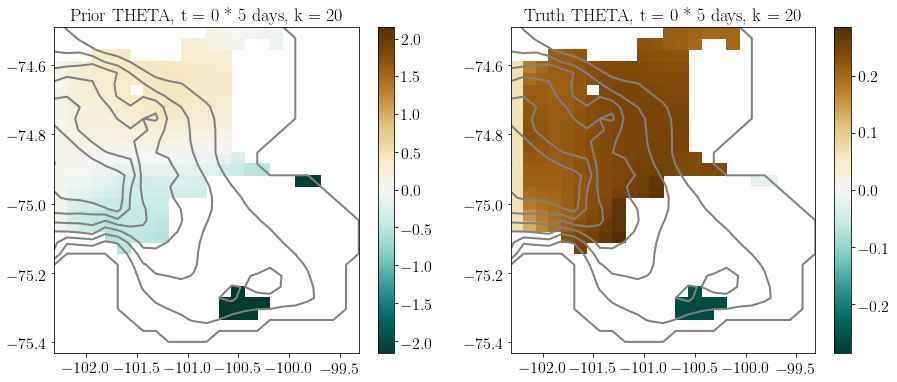

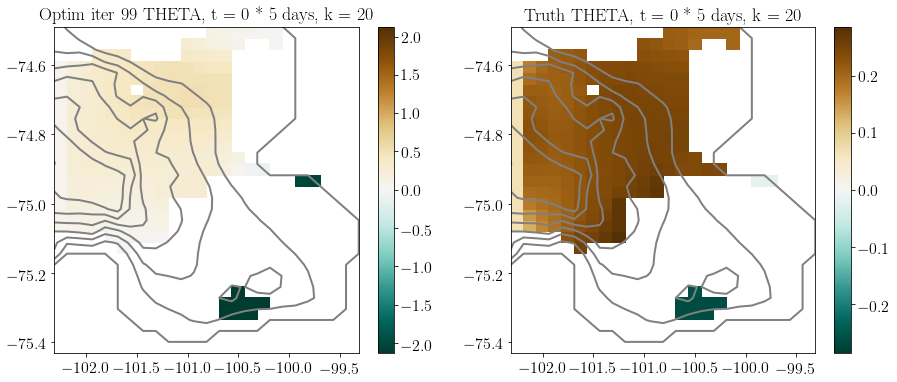

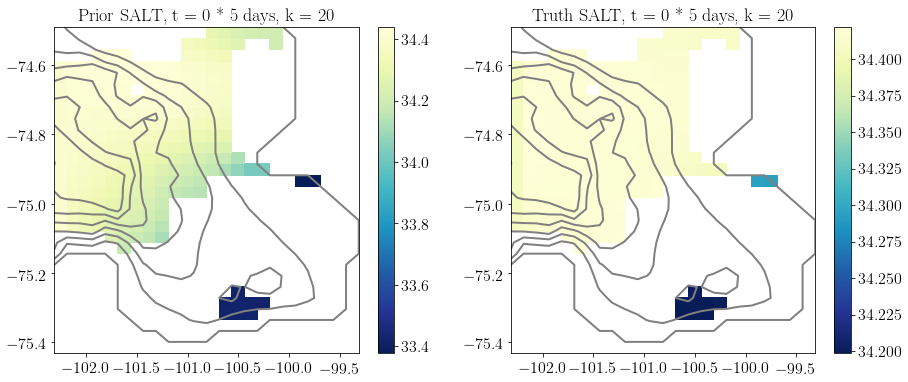

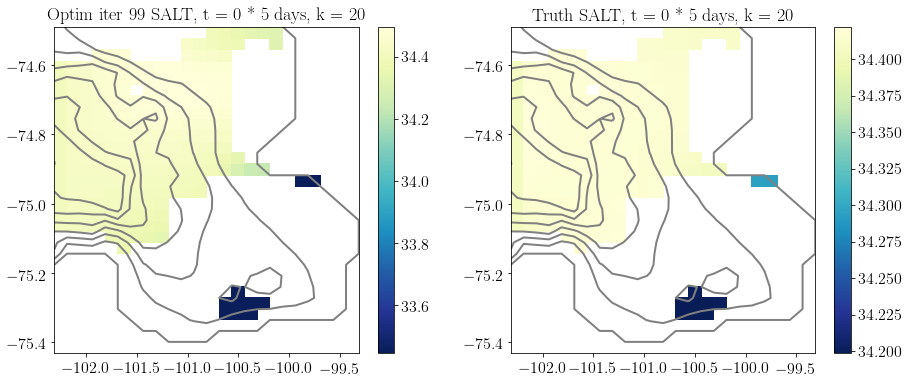

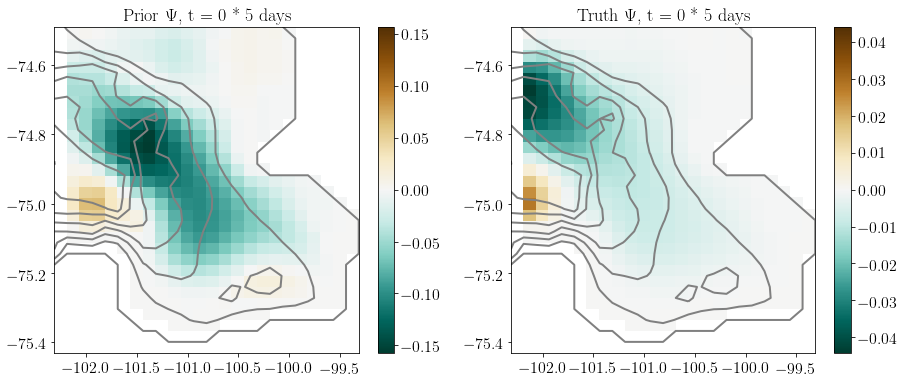

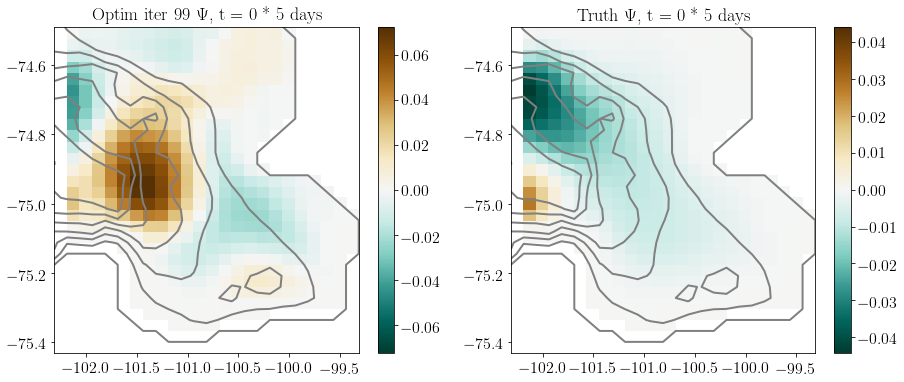

In [16]:
run_dir_prefix = '/workspace/ase-adjoint/pig/generic/shicoeff_optim_istar_month/run_ad_08'

pso.plotInitialConditionFit(run_dir_prefix=run_dir_prefix,optimIter=99,t_ind=0)
plt.show()

## Notes
- Not much improvement in the initial conditions
- Need to consider regularization parameter

# Next experiment

It seems like the dominating inhibitor in the optimization is the fact that the cost associated with initial 
condition adjustment starts to dominate the model-data misfit. 
I want the following characteristics: 
- Initial conditions should adjust away, I have no idea what they are
- Probably same with parameters, although I don't want them to adjust too intensely 
  because I'm controlling the exponent
- T/S initial conditions should probably get adjusted even more than velocity because I'm constraining it with
  observations. That is, I can weight my prior pretty low for these guys

See `shelfice_optim_istar_month_reg01`  
- Use all the same observations and prior information
- update the `data.ctrl` with `mult_genarr` = 
    - 0.01 for T/S
    - 0.1 for velocity and parameters